# Multi-Perceptron model with Softmax classification

In this notebook, I am building a multi-perceptron model i.e a neural network with 1 hidden layer. However in the output layer, instead of sigmoid unit, I am going to build a softmax unit that provides the relative probabilities of the various classes out output.

TO DO: Put up a picture of a multi-perceptron model and explain what this two layer network

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math
from sklearn.model_selection import train_test_split

In [90]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [91]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation
Use pickle to unpack to cifar data

In [92]:

def unpickle(file):
    fo = open(file, 'rb')
    data = pickle.load(fo, encoding = 'bytes')
    return data

## Importing the data

In [93]:
file = 'cifar/data_batch_1'
u = unpickle(file)

x = u[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
y = np.array(u[b'labels'])

## Visualize the data

In [94]:
classes = {"plane":0,'car':1,'bird':2,'cat':3,'deer':4,'dog':5,'frog':6,'horse':7,'ship':9,'truck':10}

In [95]:
def show_cifar_samples(x,y,class_of_interest):
        number_of_samples = 7
        idclass = classes[class_of_interest]
        y_sample = np.where(y == idclass)
        
        y_idx = y_sample[0][1:number_of_samples]
        offset = 1
        plt.figure(1)

        for i in y_idx:

            plt.subplot(number_of_samples,number_of_samples,offset)
            plt.imshow(x[i].astype('uint8'))
            if(offset == 1):
                plt.title(class_of_interest)
            offset= offset + 1
            plt.axis('off')

        plt.show()

        y_otherclass = np.where(y!=idclass)
        y_idx = y_otherclass[0][1:number_of_samples]

        offset = 1
        plt.figure(2)
        
        for i in y_idx:
            plt.subplot(number_of_samples,number_of_samples,offset)
            plt.imshow(x[i].astype('uint8'))
            if(offset == 1):
                plt.title("Other Class")
            offset= offset + 1
            plt.axis('off')

        plt.show()

In [96]:
def normalize(x):
        #Normalizing the vector
    mean_x = np.mean(x)
    stddev_x = np.std(x)
    x_output  = (x- mean_x) / stddev_x 
    
    return(x_output)

In [97]:
def generate_cifar_train_test_set(x, y, classes, show_samples = 0):

       
    if show_samples:
        show_cifar_samples(x,y,class_of_interest)

        
    x_dataset = x
    y_dataset = np.zeros([len(classes.keys()),len(y)])
    for datapoint in np.arange(len(y)):
        class_of_datapoint = y[datapoint] #For the kth datapoint y[k] will give the object class
        y_dataset[class_of_datapoint,datapoint] = 1 # The object class the kth datapoint belongs to is set to 1;
                                                    # the column index- datapoint, provides the datapoint under consideration
        
    #Resulting y_dataset is of dimension - (# of classes, number of datapoints), so before using train_test_split,
    # we will transform it. We will tranform it back to this dimensional form later.
    y_dataset = y_dataset.T

    
    xtrain, xtest, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.2)
    x_train_vector = xtrain.reshape(xtrain.shape[0],-1).T
    x_test_vector = xtest.reshape(xtest.shape[0],-1).T
    
    #Setting the dimensions of output vector to be (# of classes, number of datapoints),
    y_train = y_train.T
    y_test  = y_test.T
    
    x_train = normalize(x_train_vector)
        
    #For normalizing test data, we will use the mean and std.dev from the training data (i.e not the mean and std.dev
    # from the test data)
    mean_x = np.mean(x_train_vector)
    stddev_x = np.std(x_train_vector)
    x_test = (x_test_vector - mean_x)/stddev_x
        
        
    return(x_train,y_train,x_test,y_test)

In [113]:
x_train,y_train,x_test,y_test = generate_cifar_train_test_set(x, y, classes, show_samples = 0)

In [114]:
np.shape(x_train)

(3072, 8000)

### Sigmoid

Exponential values for moderately large numbers tend to overflow. So np.clip is used here to limit the values of the signal between -500 and 500. Since e^x is between 0 and 1, the error in using this clip is low.Additionally, here I am using a numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

In [99]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

In [186]:
def relu(x):
    x[x<0] = 0
    return(x)

In [339]:
def softmax(x):
    #for stabilization of softmax, we will calculate and subtract the max value*
    # TO DO: explain this.
    stabilize_factor = -1*np.max(x, axis = 0, keepdims = True)
    
    unnormalized_probabilities = np.exp(x+stabilize_factor)
        
    normalization_factor = np.sum(unnormalized_probabilities,axis = 0, keepdims = True)
    
    #if(normalization_factor == 0):
    #    normalized_probabilities = unnormalized_probabilities
    #else:
    normalized_probabilities = unnormalized_probabilities/normalization_factor
    
    return(normalized_probabilities)
    

### Initialize Parameters

In [340]:
def init_parameters(dim1, dim2,std=1e-1, random = True):

    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

### Forward Propogation

Here, I am assuming a single layered network. Note that event with single layered network, the layer itself can have multiple nodes. Also, I am using vectorized operations here i.e not using explicit loops. This helps in processing multiple inputs.

In [341]:
#Two layer network: Forward Prop
def fwd_prop(W1,B1,W2,B2,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0]
    #print("n_0:",n_0)
    #print("m:",m)
    #print("n_1",n_1)
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    

    Z1 = np.dot(W1,X) + B1
    #A1 = sigmoid(Z1)
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + B2
    A2 = softmax(Z2)

   
    return(A2,A1)

### Note on derivation of dZ2 from cost

$cost = -(1/m)*\sum{y_i*log(\hat y_i)}$

Now,
$\hat y_j = \frac{e^{z_j}}{\sum_i{e^{z_i}}}$

Let us say $y_2$ is the correct class. We need to calculate $\frac{\partial c}{ \partial y_2}$ and $\frac{\partial c}{ \partial y_i}$ where $i \neq 2$

1) First let us calculate:

$\frac{\partial c}{ \partial z_2} = \frac{-1}{m} * \frac{\partial }{ \partial z_2} \sum{y_i*log(\hat y_i)}$

$ = \frac{-1}{m} * \frac{\partial}{ \partial z_2} (y_1*log(\hat y_1) + y_2*log(\hat y_2) + ...)$

$ = \frac{-1}{m} * \frac{\partial}{\partial z_2}y_1*log(\frac {e^{z_1}}{\sum_i{e^{z_i}}}) + \frac{\partial }{\partial z_2}y_2*log(\frac {e^{z_2}}{\sum_i{e^{z_i}}}) + ...$

$ y_2 = 1, y_i = 0$ for $ {i\neq2} $ Because true class has value 1 and rest are 0 in the given y output

$ = \frac{-1}{m} * \frac{\partial }{\partial z_2}log(\frac {e^{z_2}}{\sum_i{e^{z_i}}})$

$ = \frac{-1}{m} * \frac{\sum_i{e^{z_i}}}{e^{z_2}} * \frac{\partial }{\partial z_2} \frac {e^{z_2}}{\sum_i{e^{z_i}}}$

$ = \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}*\frac{\partial }{\partial z_2} \frac {e^{z_2}}{e^{z_1} + e^{z_2} + e^{z_3} + ..}$

$ =  \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}* \frac{ \sum_i {e^{z_i}}*\frac{\partial }{\partial z_2} e^{z_2} - e^{z_2}*\frac{\partial }{\partial z_2} \sum_i{e^{z_i}}  }{(\sum_i{e^{z_i}})^2}$

$ =  \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}* \frac{ \sum_i {e^{z_i}}*e^{z_2} - e^{z_2}*e^{z_2}  }{(\sum_i{e^{z_i}})^2}$

$ =  \frac{-1}{m} *\frac{ \sum_i {e^{z_i}} - e^{z_2}}{\sum_i{e^{z_i}}}$

$ =  \frac{-1}{m} *(1 - \frac{e^{z_2}}{{\sum_i{e^{z_i}}}})$

$ =  \frac{1}{m} *(\frac{e^{z_2}}{{\sum_i{e^{z_i}}}} - 1)$

$ =  \frac{1}{m} *(y_2 - 1)$

$\frac{\partial c}{ \partial z_2} = \frac{1}{m} *(y_2 - 1)$  ..... (1)

2) Next let us calculate $\frac{\partial c}{ \partial z_i}$ which can be true for any $i \neq2$. Here we will take i = 1

$\frac{\partial c}{ \partial z_1} = \frac{-1}{m} * \frac{\partial }{ \partial z_1} \sum{y_i*log(\hat y_i)}$

$ = \frac{-1}{m} * \frac{\partial}{ \partial z_1} (y_1*log(\hat y_1) + y_2*log(\hat y_2) + ...)$

$ = \frac{-1}{m} * \frac{\partial}{\partial z_1}y_1*log(\frac {e^{z_1}}{\sum_i{e^{z_i}}}) + \frac{\partial }{\partial z_2}y_2*log(\frac {e^{z_1}}{\sum_i{e^{z_i}}}) + ...$

$ y_2 = 1, y_i = 0$ for $ {i\neq2} $ Because true class has value 1 and rest are 0 in the given y output

$ = \frac{-1}{m} * \frac{\partial }{\partial z_1}log(\frac {e^{z_2}}{\sum_i{e^{z_i}}})$

$ = \frac{-1}{m} * \frac{\sum_i{e^{z_i}}}{e^{z_2}} * \frac{\partial }{\partial z_1} \frac {e^{z_2}}{\sum_i{e^{z_i}}}$

$ = \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}*\frac{\partial }{\partial z_1} \frac {e^{z_2}}{e^{z_1} + e^{z_2} + e^{z_3} + ..}$

$ =  \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}* \frac{ \sum_i {e^{z_i}}*\frac{\partial }{\partial z_1} e^{z_2} - e^{z_2}*\frac{\partial }{\partial z_1} \sum_i{e^{z_i}}  }{(\sum_i{e^{z_i}})^2}$

$ =  \frac{-1}{m} *\frac{\sum_i{e^{z_i}}}{e^{z_2}}* \frac{ \sum_i {e^{z_i}}*0 - e^{z_2}*e^{z_1}  }{(\sum_i{e^{z_i}})^2}$

$ =  \frac{1}{m} *\frac{e_{z_1}}{\sum_i{e^{z_i}}}$

$ =  \frac{1}{m} * y_1$


$\frac{\partial c}{ \partial z_1} = \frac{1}{m} * y_1$  ..... (2)

Hence from equation (1) and (2) we get that the for the correct class the back prop is softmax value - 1 and for incorrect class the backprop value is softmax value itself
Hence in the upcoming back prop we can capture this as

$dZ2 = \frac{1}{m}*(A2 - Y)$ where A2 is the output of the softmax function
    

In [342]:

def back_prop(A1,W1,B1,A2,W2,B2,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    n_2 = np.shape(W2)[0] 
      
    cost = (-1/m)*np.sum(Y*np.log(A2) + (1-Y)*np.log(1-A2)) + 0.5*1e-5*np.sum(W1*W1) + 0.5*1e-5*np.sum(W2*W2)
       
    #A2 is the output of the softmax function of Z2 i.e A2 = e^Z2/Sum(e^Z2)
    # It is easier to just derive dcost/dZ2 directly
    # The explanation of derivation of dZ2 is given above
    
    dZ2 = (1/m)*(A2 - Y)    

    #shape(dW2) = shape(W2) = (n_2,n_1)
    #Note that (1/m) factor is taken care of in the calculation of dZ2
    
    dW2 = np.dot(dZ2, A1.T) # (dZ2) = (n_2,m), A1 ->(n_1,m)
                                    # Hence result shape = (n_2,n_1) = (1,n_1)
    
    # Z2 = np.dot(W2,A1) + B2
    # dB2 = dZ2*1
    # shape(dB2) = shape(B2) = (n_2,1) = ; (dZ2) = (n_2,m) hence to get (n_2,1) we sum across all columns
    dB2 = np.sum(dZ2, axis = 1, keepdims = True) 
    
        
    # Z2 = np.dot(W2,A1) + B2
    # dA1 = dZ2*W2 (consider the dimensions)
    #(A1) = (n_1,m); (dZ2) = (n_2,m), (W2) = (n_2,n_1)
    # Hence dot product of W2.T and dZ2 gives correct output dimenstion for dA1
    dA1 = np.dot(W2.T,dZ2) 
    
    ###--------Sigmoid Backprop-------##
    # A1 = sigmoid(Z1)
    # (A1) = (n_1,m)
    # (Z1) = (n_1,m)
    #dZ1 = dA1*(A1)*(1-A1) #(dA1) = (n_1,m), (A1) = (n_1,m), hence elementwise product for preserving dimensions
    ##--------------------------------##
    
    ##---------- RELU Backprop---------##
    # A1 = Relu(Z1) i.e Z1 = Z1 if Z1>0 else 0
    # hence when derivative A1 w.r.t Z1 = 1 if Z1>0 else 0
    
    # NOTE: Uncomment following 4 lines for relu and comment the above dZ1 = dA1*(A1)*(1-A1)
    Z1 = np.dot(W1,X) + B1
    dA1dZ1 = np.zeros(np.shape(Z1))
    dA1dZ1[Z1>0] = 1
    dZ1 = dA1*dA1dZ1

    ##---------------------------------##
    
    # Z1 = np.dot(W1,X) + B1
    # dW1 = dZ1*X
    # (dZ1) = (n_1,m); (X) = n_0,m); (W1) = (n_1,n_0). hence (dW1) = (n_1,n_0)
    # product of dZ1* X.T gives the correct putput dimension for X
    dW1 = np.dot(dZ1, X.T) #(dZ1) = (n_1,m); (X) = (n_0,m) hence dot product(dZ1,X.T) = (n_1,n_0)
    
    # Z1 = np.dot(W1,X) + B1
    # dB1 = dZ1*1
    #(dZ1) = (n_1,m); (B1) = (n_1,1) hence (db1 = (n_1,1)
    # dB1 = np.sum (dZ1) along all columns to get output dimension
    
    #(B1) = (n_1,1) which gets broadcasted to (n_1,m); hence (dB1) = (n_1,1)
    dB1 = np.sum(dZ1, axis = 1, keepdims = True) #(dZ1) = (n_1,m) so sum along all the columns to get (n_1,1)
    
    grads ={"dW2": dW2, "dB2":dB2,"dW1": dW1, "dB1":dB1}
    

    return(grads,cost)

In [343]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1,n_2):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= True)
    B1 = init_parameters(n_1,1, random = True)
    
    W2 = init_parameters(n_2, n_1, random= True)
    B2 = init_parameters(n_2,1, random = True)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A2,A1 = fwd_prop(W1,B1,W2,B2,X,Y)
    
        grads,cost = back_prop(A1,W1,B1,A2,W2,B2,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        W2 = W2 - learning_rate*grads["dW2"]
        B2 = B2 - learning_rate*grads["dB2"]

        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1,"W2":W2,"B2":B2}
    
    return(parameter,loss_array)

In [344]:
x_train,y_train,x_test,y_test = generate_cifar_train_test_set(x, y, classes, show_samples = 0)

In [345]:
#Lets test on the CIFAR dataset
params, loss_array = run_grad_desc(1000,1e-1,x_train, y_train, n_1 = 50, n_2 = 10)
#Training data accuracy

/home/animo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/home/animo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in multiply


In [315]:
y_train_predict,A1 = fwd_prop(params["W1"],params["B1"],params["W2"],params["B2"],x_train,y_train)
y_train_predict_vector = np.argmax(y_train_predict, axis = 0)
y_train_vector = np.argmax(y_train, axis = 0)

/home/animo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [298]:
accuracy = np.sum(y_train_predict_vector == y_train_vector)/len(y_train_vector)
accuracy

0.15975

In [299]:
#Test data accuracy
y_predict,A1 = fwd_prop(params["W1"],params["B1"],params["W2"],params["B2"],x_test,y_test)
y_test_predict_vector = np.argmax(y_predict, axis = 0)
y_test_vector = np.argmax(y_test, axis = 0)
accuracy = np.sum(y_test_predict_vector == y_test_vector)/len(y_test_vector)
accuracy

0.14399999999999999

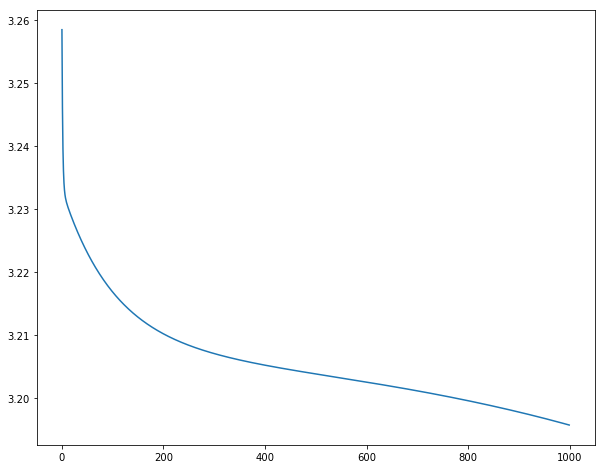

In [300]:
plt.plot(loss_array)